In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/DL Project')
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks/DL Project


In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers
import collections
from keras.callbacks import ModelCheckpoint,CSVLogger
from sklearn.metrics import classification_report,confusion_matrix
import itertools

## ***Extracting Train data***

In [ ]:
train_datagen = ImageDataGenerator( rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2)
train_set = train_datagen.flow_from_directory(
        'data/Train',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical',
        shuffle=True)

Found 5349 images belonging to 3 classes.


## ***Extracting validation data***

In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_set = valid_datagen.flow_from_directory(
        'data/Valid',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical',
        shuffle=True)

Found 1750 images belonging to 3 classes.


## ***Extracting Test data***

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
        'data/Test',
        target_size=(256, 256),
        batch_size=150,
        class_mode='categorical',
        shuffle=True)

Found 1720 images belonging to 3 classes.


In [ ]:
print("Labels: ", train_set.class_indices)
print("=========================================================")
print("Instance of Train set: ", train_set.samples)
print("No. of batch: ", len(train_set))
print("Output dimensions of image: ", train_set.image_shape)
counter_train = collections.Counter(train_set.classes)
print("Sample per class: ", counter_train.items())
print("=========================================================")
print("Instance of Validation set", valid_set.samples)
print("No. of batch: ", len(valid_set))
print("Output dimensions of image: ", valid_set.image_shape)
counter_valid = collections.Counter(valid_set.classes)
print("Sample per class: ", counter_valid.items())
print("=========================================================")
print("Instance of Test set", test_set.samples)
print("No. of batch: ", len(test_set))
print("Output dimensions of image: ", test_set.image_shape)
counter_test = collections.Counter(test_set.classes)
print("Sample per class: ", counter_test.items())

Labels:  {'Cap': 0, 'Cov': 1, 'Norm': 2}
Instance of Train set:  5349
No. of batch:  168
Output dimensions of image:  (256, 256, 3)
Sample per class:  dict_items([(0, 724), (1, 2307), (2, 2318)])
Instance of Validation set 1750
No. of batch:  55
Output dimensions of image:  (256, 256, 3)
Sample per class:  dict_items([(0, 234), (1, 758), (2, 758)])
Instance of Test set 1720
No. of batch:  12
Output dimensions of image:  (256, 256, 3)
Sample per class:  dict_items([(0, 220), (1, 750), (2, 750)])


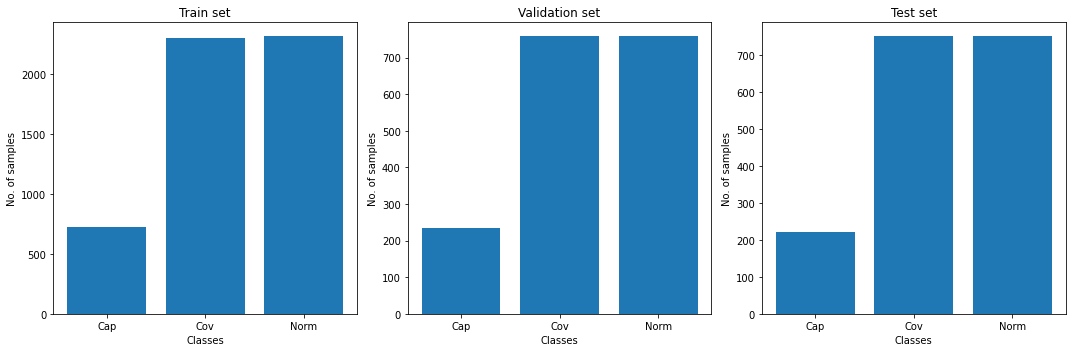

In [ ]:
class_key = ['Cap', 'Cov', 'Norm']

plt.subplots(figsize=(15, 5))

# counter_train = collections.Counter(train_set.classes)
# print("Sampes in each class: ", counter_train.items())
# print()
plt.subplot(1, 3, 1) 
plt.bar(class_key, counter_train.values())
plt.xlabel('Classes')
plt.ylabel('No. of samples')
plt.title("Train set")
# plt.show()

# counter_valid = collections.Counter(valid_set.classes)
# print("Sampes in each class: ", counter_valid.items())
# print()
plt.subplot(1, 3, 2)
plt.bar(class_key, counter_valid.values())
plt.xlabel('Classes')
plt.ylabel('No. of samples')
plt.title("Validation set")
# plt.show()

# counter_test = collections.Counter(test_set.classes)
# print("Sampes in each class: ", counter_test.items())
# print()
plt.subplot(1, 3, 3)
plt.bar(class_key, counter_test.values())
plt.xlabel('Classes')
plt.ylabel('No. of samples')
plt.title("Test set")
# plt.show()

plt.tight_layout()
plt.show()

## **Buildng Model**

In [22]:
from keras import models
from keras import layers

In [24]:
base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=(256, 256, 3))
avg =  tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = tf.keras.layers.Dropout(0.2)(avg)
output = tf.keras.layers.Dense(3,activation ="softmax")(dropout)
model = tf.keras.Model(inputs=base_model.input,outputs=output)

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [26]:
from keras.callbacks import ModelCheckpoint,CSVLogger
mc = ModelCheckpoint('resnet50_proj_1.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
cv = keras.callbacks.CSVLogger('resnet50_proj_1.csv', separator=',', append=False)

In [ ]:
weights = {0:3, 1:1, 2:1}
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(train_set, validation_data=valid_set, class_weight=weights, callbacks=[mc, cv] , epochs=25, verbose=1)

Epoch 1/25
168/168 [==============================] - ETA: 0s - loss: 0.8431 - accuracy: 0.6958
Epoch 00001: val_loss improved from inf to 7.95802, saving model to resnet50_proj_1.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


168/168 [==============================] - 185s 1s/step - loss: 0.8431 - accuracy: 0.6958 - val_loss: 7.9580 - val_accuracy: 0.4331
Epoch 2/25
168/168 [==============================] - ETA: 0s - loss: 0.3726 - accuracy: 0.8661
Epoch 00002: val_loss did not improve from 7.95802
168/168 [==============================] - 173s 1s/step - loss: 0.3726 - accuracy: 0.8661 - val_loss: 9.6092 - val_accuracy: 0.4331
Epoch 3/25
168/168 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.9226
Epoch 00003: val_loss improved from 7.95802 to 3.65933, saving model to resnet50_proj_1.h5
168/168 [==============================] - 173s 1s/step - loss: 0.2323 - accuracy: 0.9226 - val_loss: 3.6593 - val_accuracy: 0.4331
Epoch 4/25
168/168 [==============================] - ETA: 0s - loss: 0.1564 - accuracy: 0.9490
Epoch 00004: val_loss improved from 3.65933 to 2.68219, saving model to resnet50_proj_1.h5
168/168 [==============================] - 175s 1s/step - loss: 0.1564 - accuracy: 

In [ ]:
test_loss,test_acc = model.evaluate(test_set)
print(test_loss)
print(test_acc) 

In [ ]:
target_names = []
for key in train_set.class_indices:
    target_names.append(key)
# print(target_names)

Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_set.classes, y_pred, target_names=target_names))

In [17]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(test_set.classes, y_pred, normalize='all')
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [19]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
xc=range(len(train_loss))

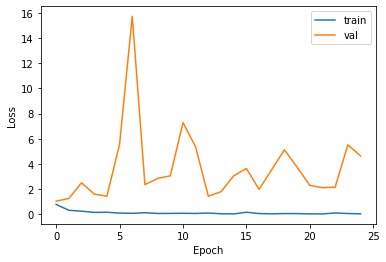

In [20]:
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

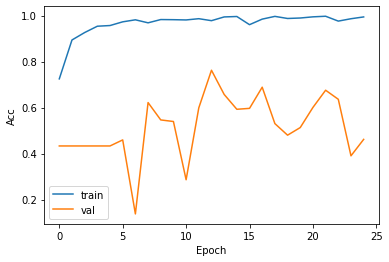

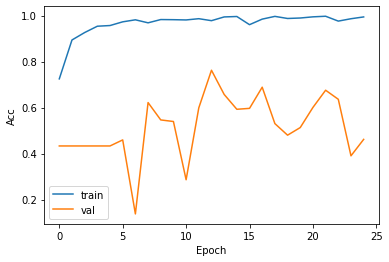

In [21]:
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])